In [1]:
import os
from time import time
import yaml

from argparse import ArgumentParser, Namespace

from s3ts.api.nets.wrapper import WrapperModel
from s3ts.helper_functions import load_dm, str_time, get_parser

from pytorch_lightning import Trainer
from pytorch_lightning.utilities.model_summary import summarize

from s3ts.helper_functions import get_model

import torch
import numpy as np

import matplotlib.pyplot as plt

In [2]:
p = get_parser()

In [3]:
args = p.parse_args("--mode ts --dataset UCI-HAR --lr 0.001 --subjects_for_test 21 --window_size 25 --window_stride 1 --batch_size 128 --encoder_architecture cnn_gap --encoder_features 20 --decoder_architecture mlp --decoder_features 32 --decoder_layers 1 --pattern_size 32 --rho 0.1 --compute_n 300 --pattern_type syn --num_workers 8 --max_epochs 3 --normalize --reduce_imbalance --training_dir training_cv2 --n_val_subjects 4 --weight_decayL1 0 --weight_decayL2 0".split())

In [4]:
dm = load_dm(args)

class_changes = [0] + list(np.nonzero(np.diff(dm.stsds.SCS))[0])
print(len(class_changes), "number of class changes")

Loaded dataset UCI-HAR with a total of 815614 observations for window size 25
Sampling 59084 (balanced) observations per epoch.
Using 708997 observations for training, 106617 for validation and 25512 observations for test
1787 number of class changes


In [25]:
2**int(np.log2(class_changes[2] - class_changes[1]))

512

In [40]:
dm.stsds.STS[0, (class_changes[1]+1):(class_changes[1]+513)].mean()*512

tensor(259.4167)

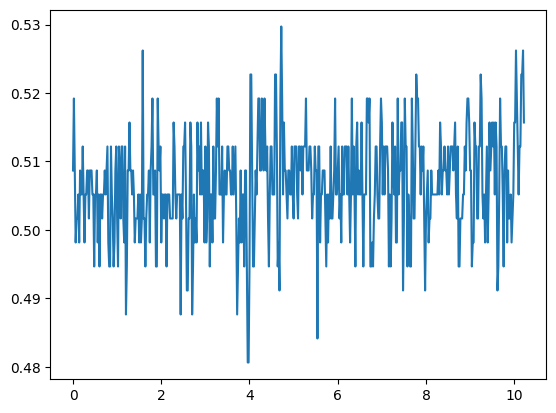

In [38]:
plt.plot(np.arange(512)/50, dm.stsds.STS[0, (class_changes[1]+1):(class_changes[1]+513)] )

In [41]:
fft_res = np.fft.fft(dm.stsds.STS[0, (class_changes[2]+1):(class_changes[3]+1)], n=512)

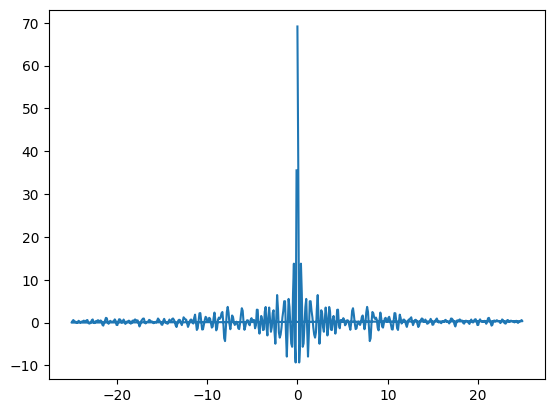

In [43]:
plt.plot(np.fft.fftfreq(512, 0.02), fft_res.real)

In [35]:
np.fft.ifft(fft_res).real

array([0.50868654, 0.51920521, 0.50868654, 0.4981679 , 0.50167412,
       0.50167412, 0.50518036, 0.4981679 , 0.50868654, 0.50518036,
       0.50518036, 0.51219279, 0.50518036, 0.4981679 , 0.50518036,
       0.50518036, 0.50868654, 0.50868654, 0.50167412, 0.50868654,
       0.50868654, 0.50868654, 0.50518036, 0.50518036, 0.49466169,
       0.50518036, 0.50518036, 0.50868654, 0.4981679 , 0.50518036,
       0.49466169, 0.50518036, 0.50518036, 0.50167412, 0.50518036,
       0.50518036, 0.50868654, 0.50518036, 0.50868654, 0.51219279,
       0.4981679 , 0.49466169, 0.49466169, 0.51219279, 0.50518036,
       0.50167412, 0.49466169, 0.4981679 , 0.50868654, 0.51219279,
       0.50167412, 0.49466169, 0.51219279, 0.50868654, 0.50167412,
       0.51219279, 0.51219279, 0.50167412, 0.4981679 , 0.51219279,
       0.48764923, 0.49466169, 0.50868654, 0.50868654, 0.51569903,
       0.50868654, 0.50868654, 0.50518036, 0.50868654, 0.50518036,
       0.4981679 , 0.50167412, 0.50167412, 0.50167412, 0.50518

In [7]:
first_frequency = {}
second_frequency = {}

In [89]:
def process_fft(STS, SCS, sampling, window_size):
    class_changes = [0] + list(np.nonzero(np.diff(SCS))[0])

    top10 = {} # a dict for each class
    classes = np.unique(SCS)
    for c in classes:
        top10[c] = [{} for i in range(STS.shape[0])] # a dict for each channel

    for i in range(len(class_changes)-1):
        current_class = SCS[class_changes[i]+1].item()

        series_part = STS[:, (class_changes[i]+1):(class_changes[i+1]+1)]
        fft_size = 2**int(np.log2(series_part.shape[1]))
        fft_short = np.fft.fft(series_part, axis=-1, n=fft_size)
        fft_freq = np.fft.fftfreq(fft_size, d=1/sampling) # highest frequencies for signals of sampling rate 50 is 25

        fft_short_sort = np.argsort(np.abs(fft_short), axis=-1) # sort is ascending magnitudes

        fft_freq_sort = np.abs(fft_freq[fft_short_sort][:,-50:]) # get the 10 for each channel frequencies (+-) with highest amplitude

        for c in range(fft_freq_sort.shape[0]):
            for j in range(fft_freq_sort.shape[1]):
                top10[current_class][c][fft_freq_sort[c, j]] = top10[current_class][c].get(fft_freq_sort[c, j], 0) + 1

    return top10

In [71]:
def get_predominant_frequency(fft_process_result):
    classes_list = list(filter(lambda x: x!=100, fft_process_result.keys()))
    num_classes = len(classes_list)

    out = np.zeros((num_classes, len(fft_process_result[0]))) # (n, c) we get a predominant frequency per channel, per class

    for i, c in enumerate(classes_list):
        for j, channel_result in enumerate(fft_process_result[c]):
            sorted_fr = list(filter(lambda x: x[0]>0, sorted(channel_result.items(), key=lambda x:x[1])))
            out[i, j] = sorted_fr[-1][0]
    
    return out

In [90]:
res = process_fft(dm.stsds.STS, dm.stsds.SCS, 50, 48)

In [91]:
get_predominant_frequency(res)

array([[1.7578125 , 1.7578125 , 0.87890625, 0.87890625, 0.87890625,
        0.87890625],
       [1.5625    , 1.7578125 , 0.78125   , 0.09765625, 0.78125   ,
        0.78125   ],
       [1.7578125 , 3.125     , 0.87890625, 0.390625  , 0.87890625,
        1.7578125 ],
       [0.09765625, 0.09765625, 0.29296875, 0.78125   , 0.48828125,
        0.48828125],
       [0.09765625, 0.09765625, 0.09765625, 0.390625  , 0.68359375,
        0.390625  ],
       [0.09765625, 0.09765625, 0.09765625, 1.46484375, 0.390625  ,
        0.390625  ],
       [0.78125   , 0.78125   , 1.5625    , 0.78125   , 2.34375   ,
        0.78125   ],
       [0.78125   , 0.78125   , 0.78125   , 0.78125   , 0.78125   ,
        0.78125   ],
       [0.390625  , 0.390625  , 0.390625  , 0.390625  , 0.78125   ,
        0.78125   ],
       [0.78125   , 0.78125   , 0.78125   , 0.78125   , 0.78125   ,
        0.78125   ],
       [0.390625  , 0.390625  , 0.390625  , 0.390625  , 0.78125   ,
        0.390625  ],
       [0.78125   , 1

In [73]:
pred_f = get_predominant_frequency(res)

In [88]:
pred_f

array([[1.7578125 , 1.7578125 , 0.87890625, 0.87890625, 0.87890625,
        0.87890625],
       [1.66015625, 1.66015625, 0.78125   , 0.09765625, 0.78125   ,
        0.78125   ],
       [1.7578125 , 1.7578125 , 0.87890625, 0.29296875, 0.87890625,
        1.7578125 ],
       [0.09765625, 0.09765625, 0.09765625, 0.390625  , 0.390625  ,
        0.390625  ],
       [0.04882812, 0.09765625, 0.09765625, 0.29296875, 0.1953125 ,
        0.390625  ],
       [0.09765625, 0.04882812, 0.04882812, 0.390625  , 0.390625  ,
        0.390625  ],
       [0.390625  , 0.390625  , 0.390625  , 0.78125   , 0.390625  ,
        0.390625  ],
       [0.78125   , 0.78125   , 0.78125   , 0.78125   , 0.78125   ,
        0.78125   ],
       [0.390625  , 0.390625  , 0.390625  , 0.390625  , 0.390625  ,
        0.390625  ],
       [0.390625  , 0.390625  , 0.390625  , 0.390625  , 0.390625  ,
        0.390625  ],
       [0.390625  , 0.390625  , 0.390625  , 0.78125   , 0.390625  ,
        0.390625  ],
       [0.390625  , 0

In [76]:
np.diff(np.unique(pred_f))

array([0.04882812, 0.09765625, 0.09765625, 0.09765625, 0.390625  ,
       0.09765625, 0.78125   , 0.09765625])

In [77]:
np.unique(pred_f)

array([0.04882812, 0.09765625, 0.1953125 , 0.29296875, 0.390625  ,
       0.78125   , 0.87890625, 1.66015625, 1.7578125 ])

In [82]:
np.unique(pred_f)[indices]

array([0.04882812, 0.04882812, 0.04882812, 0.04882812, 0.04882812,
       0.09765625, 0.04882812, 0.09765625, 0.04882812])

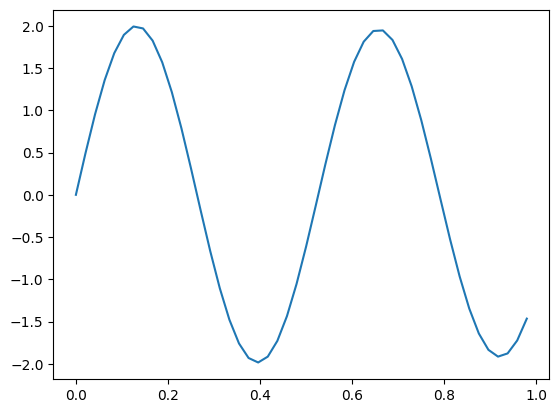

In [14]:
plt.plot(np.arange(48)/48, np.sin(2*np.pi *1.85 *np.arange(48)/48) +np.sin(2*np.pi *1.95 *np.arange(48)/48))

In [50]:
sorted(res[4][0].items(), key=lambda x:x[1])[-6:]

[(4.1015625, 14),
 (0.146484375, 22),
 (0.1953125, 24),
 (0.09765625, 48),
 (0.048828125, 70),
 (0.0, 120)]